In [1]:
import random
from collections import Counter
import itertools
import math

import networkx as nx
import numpy as np
import pandas as pd
from scipy.special import softmax
from tqdm import trange, tqdm

In [2]:
class Car:
    def __init__(self, id, source, target, speed, created_at_step=0, position=None) -> None:
        self.id = id
        self.source = source
        self.target = target
        self.speed = speed
        self.created_at_step = created_at_step
        self.position = position if position is not None else ((source, source), 1.0) # (v, w), p
        self.route = [self.position[0][0], self.position[0][1]]

    def __repr__(self) -> str:
        (v, w), p = self.position
        return f'<Car {self.id} ({self.source:2} -> {self.target:2}) at {p:.2} of {(v, w)}>'

    def act(self, network):
        current_node = self.position[0][1]
        if current_node == self.target or not nx.has_path(network, current_node, self.target):
            return current_node
        else:
            anticipated_latencies = {(v, w): attr['latency_fn'](attr['flow'] + (1 if v == current_node else 0)) for v, w, attr in network.edges(data=True)}
            choice = random.choice(
                list(nx.all_shortest_paths(network, current_node, self.target,
                                           weight=lambda v, w, _: anticipated_latencies[(v, w)])))
            self.speed = 1 / (anticipated_latencies[(choice[0], choice[1])])

            print(f'Car {self.id} at {current_node} chooses {choice[1]} for latencies {anticipated_latencies}.')

            self.route.append(choice[1])
            return choice[1]

    def reset(self, source, step):
        self.source = source
        self.created_at_step = step

        self.position = (source, source), 1.0 # (v, w), p
        self.route = [source]
        self.speed = 0
            

class TrafficModel:
    def __init__(self, network, cars) -> None:
        self.network = network
        self.cars = cars

    def update_latencies(self):
        nx.set_edge_attributes(self.network, {(v, w): attr['latency_fn'](attr['flow']) for v, w, attr in self.network.edges(data=True)}, 'latency')
        nx.set_edge_attributes(self.network, {(v, w): attr['latency_fn'](attr['flow'] + 1) for v, w, attr in self.network.edges(data=True)}, 'anticipated_latency')

    def update_latency(self, edge):
        self.network.edges[edge]['latency'] = self.network.edges[edge]['latency_fn'](self.network.edges[edge]['flow'])
        self.network.edges[edge]['anticipated_latency'] = self.network.edges[edge]['latency_fn'](self.network.edges[edge]['flow'] + 1)

    @property
    def allowed_network(self):
        return nx.restricted_view(self.network, [], [(v, w) for v, w, allowed in self.network.edges(data='allowed') if not allowed])

    def decrease_flow(self, edge):
        self.set_flow(edge, self.network.edges[edge]['flow'] - 1)

    def increase_flow(self, edge):
        self.set_flow(edge, self.network.edges[edge]['flow'] + 1)

    def set_flow(self, edge, flow):
        self.network.edges[edge]['flow'] = flow
        self.update_latency(edge)

In [35]:
def run(model, number_of_steps, verbose=False):
    flow = []
    latency = []
    stats = []
    for step in range(number_of_steps):
        print('### next round')
        if verbose:
            print(f'Step {step}:')
            print(f'Positions before step {step}: {[car.position for car in model.cars.values()]}')

        # Update flow and latencies
        flow_counter = Counter(car.position[0] for car in model.cars.values())
        nx.set_edge_attributes(model.network, {edge: flow_counter[edge] for edge in model.network.edges}, 'flow')
        model.update_latencies()

        flow.append(nx.get_edge_attributes(model.network, 'flow'))
        latency.append(nx.get_edge_attributes(model.network, 'latency'))

        if verbose:
            print(f'{nx.get_edge_attributes(model.network, "flow")=}')
            print(f'{nx.get_edge_attributes(model.network, "latency")=}')
            print(f'{nx.get_edge_attributes(model.network, "anticipated_latency")=}')

        # Advance agents
        for car in model.cars.values():
            car.position = (car.position[0], min(car.position[1] + car.speed, 1.0))

            if car.position[1] >= 1.0:
                model.decrease_flow(car.position[0])

        if verbose:
            print(f'Positions after step {step}: {[car.position for car in model.cars.values()]}')

        if verbose:
            print(f'{nx.get_edge_attributes(model.network, "flow")=}')
            print(f'{nx.get_edge_attributes(model.network, "latency")=}')
            print(f'{nx.get_edge_attributes(model.network, "anticipated_latency")=}')

        # Re-spawn cars which have arrived
        for car in model.cars.values():
            if car.position[0][0] == car.target or (car.position[0][1] == car.target and car.position[1] == 1.0):
                stats.append({'source': car.source, 'target': car.target, 'steps': step - car.created_at_step, 'route': tuple(car.route)})

                if verbose:
                    print(f'Car {car.id} reached its target after {step - car.created_at_step} steps.')

                # source = np.random.randint(3)
                car.reset(0, step)

        if verbose:
            print(f'Positions after re-spawning at step {step}: {[car.position for car in model.cars.values()]}')

        # Let agents make decisions
        for car in np.random.permutation([car for car in model.cars.values() if car.position[1] == 1.0]):
            car.position = (car.position[0][1], car.act(model.allowed_network)), 0.0
            model.increase_flow(car.position[0])

        if verbose:
            print(f'{nx.get_edge_attributes(model.network, "flow")=}')
            print(f'{nx.get_edge_attributes(model.network, "latency")=}')
            print(f'{nx.get_edge_attributes(model.network, "anticipated_latency")=}')

    return pd.DataFrame(flow), pd.DataFrame(latency), pd.DataFrame(stats)

In [36]:
network = nx.DiGraph([(0, 0), (0, 1), (0, 2), (1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)])

node_positions = {
    0: np.array([0, 0]),
    1: np.array([0.33, 0]),
    2: np.array([0.66, 0]),
    3: np.array([1, 0])
}

nx.set_node_attributes(network, node_positions, 'position')

# Latency is defined in terms of the load, i.e., the number of cars on the road
latency_fns = {
    (0, 0): lambda n: 1,
    (0, 1): lambda n: n,
    (0, 2): lambda n: 11,
    (1, 1): lambda n: 1,
    (1, 2): lambda n: 1,
    (1, 3): lambda n: 11,
    (2, 2): lambda n: 1,
    (2, 3): lambda n: n,
    (3, 3): lambda n: 1
}

nx.set_edge_attributes(network, latency_fns, 'latency_fn')

nx.set_edge_attributes(network, 0, 'flow')
nx.set_edge_attributes(network, 0, 'utilization')

nx.set_edge_attributes(network, True, 'allowed')

number_of_cars = 2
# cars = {id: Car(id, 0, 3) for id, source in zip(range(number_of_cars), np.random.randint(3, size=number_of_cars))}

### Two Car Debugging

In [71]:
cars = {
    0: Car( 0, 0, 3, 1, position=((0, 1), 0)),
    1: Car( 1, 0, 3, 1, position=((1, 2), 0))
}

model = TrafficModel(network, cars)

flow, latency, stats = run(model, 15, verbose=False)

stats.groupby('route').count()

### next round
Car 1 at 2 chooses 3 for latencies {(0, 0): 1, (0, 1): 0, (0, 2): 11, (1, 1): 1, (1, 2): 1, (1, 3): 11, (2, 2): 1, (2, 3): 1, (3, 3): 1}.
Car 0 at 1 chooses 2 for latencies {(0, 0): 1, (0, 1): 0, (0, 2): 11, (1, 1): 1, (1, 2): 1, (1, 3): 11, (2, 2): 1, (2, 3): 1, (3, 3): 1}.
### next round
Car 1 at 0 chooses 1 for latencies {(0, 0): 1, (0, 1): 1, (0, 2): 11, (1, 1): 1, (1, 2): 1, (1, 3): 11, (2, 2): 1, (2, 3): 0, (3, 3): 1}.
Car 0 at 2 chooses 3 for latencies {(0, 0): 1, (0, 1): 1, (0, 2): 11, (1, 1): 1, (1, 2): 1, (1, 3): 11, (2, 2): 1, (2, 3): 1, (3, 3): 1}.
### next round
Car 1 at 1 chooses 2 for latencies {(0, 0): 1, (0, 1): 0, (0, 2): 11, (1, 1): 1, (1, 2): 1, (1, 3): 11, (2, 2): 1, (2, 3): 0, (3, 3): 1}.
Car 0 at 0 chooses 1 for latencies {(0, 0): 1, (0, 1): 1, (0, 2): 11, (1, 1): 1, (1, 2): 1, (1, 3): 11, (2, 2): 1, (2, 3): 0, (3, 3): 1}.
### next round
Car 0 at 1 chooses 2 for latencies {(0, 0): 1, (0, 1): 0, (0, 2): 11, (1, 1): 1, (1, 2): 1, (1, 3): 11, (2, 2): 

,source,target,steps
route,,,
"(0, 1, 2, 3)",9,9,9
"(1, 2, 3)",1,1,1


<Axes: >

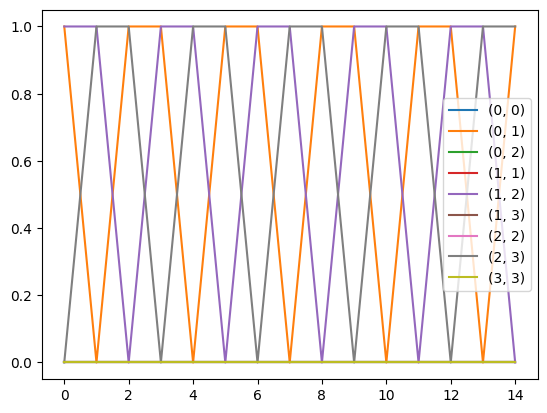

In [72]:
flow.plot()

<Axes: >

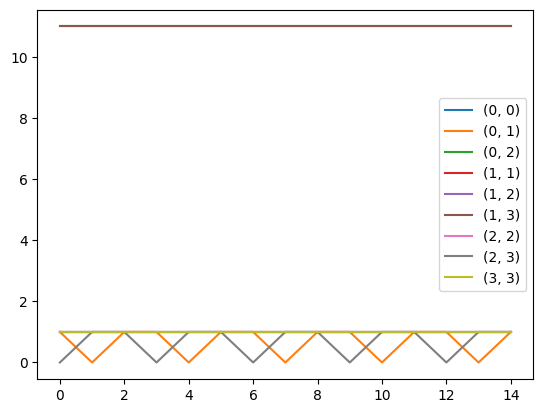

In [73]:
latency.plot()

### 30 cars with open middle edge

In [ ]:
cars = {
     0: Car( 0, 0, 3, 1/4, position=((0, 1), 0 / 4)),
     1: Car( 1, 0, 3, 1/4, position=((0, 1), 1 / 4)),
     2: Car( 2, 0, 3, 1/4, position=((0, 1), 2 / 4)),
     3: Car( 3, 0, 3, 1/4, position=((0, 1), 3 / 4)),
     4: Car( 4, 0, 3, 1/11, position=((1, 3), 0 / 11)),
     5: Car( 5, 0, 3, 1/11, position=((1, 3), 1 / 11)),
     6: Car( 6, 0, 3, 1/11, position=((1, 3), 2 / 11)),
     7: Car( 7, 0, 3, 1/11, position=((1, 3), 3 / 11)),
     8: Car( 8, 0, 3, 1/11, position=((1, 3), 4 / 11)),
     9: Car( 9, 0, 3, 1/11, position=((1, 3), 5 / 11)),
    10: Car(10, 0, 3, 1/11, position=((1, 3), 6 / 11)),
    11: Car(11, 0, 3, 1/11, position=((1, 3), 7 / 11)),
    12: Car(12, 0, 3, 1/11, position=((1, 3), 8 / 11)),
    13: Car(13, 0, 3, 1/11, position=((1, 3), 9 / 11)),
    14: Car(14, 0, 3, 1/11, position=((1, 3), 10 / 11)),
    15: Car(15, 0, 3, 1/11, position=((0, 2), 0 / 11)),
    16: Car(16, 0, 3, 1/11, position=((0, 2), 1 / 11)),
    17: Car(17, 0, 3, 1/11, position=((0, 2), 2 / 11)),
    18: Car(18, 0, 3, 1/11, position=((0, 2), 3 / 11)),
    19: Car(19, 0, 3, 1/11, position=((0, 2), 4 / 11)),
    20: Car(20, 0, 3, 1/11, position=((0, 2), 5 / 11)),
    21: Car(21, 0, 3, 1/11, position=((0, 2), 6 / 11)),
    22: Car(22, 0, 3, 1/11, position=((0, 2), 7 / 11)),
    23: Car(23, 0, 3, 1/11, position=((0, 2), 8 / 11)),
    24: Car(24, 0, 3, 1/11, position=((0, 2), 9 / 11)),
    25: Car(25, 0, 3, 1/11, position=((0, 2), 10 / 11)),
    26: Car(26, 0, 3, 1/4, position=((2, 3), 0 / 4)),
    27: Car(27, 0, 3, 1/4, position=((2, 3), 1 / 4)),
    28: Car(28, 0, 3, 1/4, position=((2, 3), 2 / 4)),
    29: Car(29, 0, 3, 1/4, position=((2, 3), 3 / 4)),
}

model = TrafficModel(network, cars)
model.network[1][2]['allowed'] = True

flow, latency, stats = run(model, 5000, verbose=False)

In [91]:
stats.groupby('route').count()

,source,target,steps
route,,,
"(0, 1, 2, 3)",2612,2612,2612
"(0, 1, 3)",2244,2244,2244
"(0, 2, 3)",2233,2233,2233
"(1, 3)",11,11,11
"(2, 3)",4,4,4


In [92]:
stats.groupby('route').mean()

,source,target,steps
route,,,
"(0, 1, 2, 3)",0.0,3.0,21.020291
"(0, 1, 3)",0.0,3.0,20.204100
"(0, 2, 3)",0.0,3.0,22.095835
"(1, 3)",0.0,3.0,5.000000
"(2, 3)",0.0,3.0,1.500000


In [93]:
stats['steps'].mean()

21.06475225225225

<Axes: >

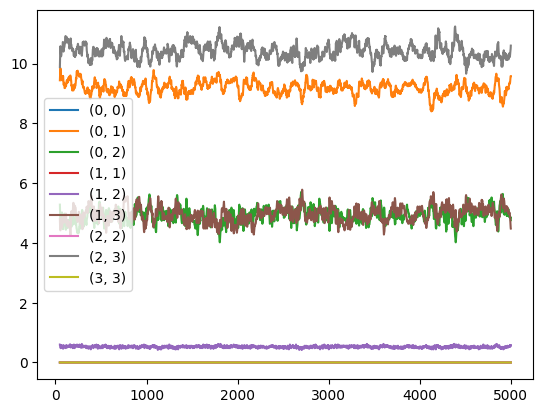

In [95]:
flow.rolling(window=50).mean().plot()

<Axes: >

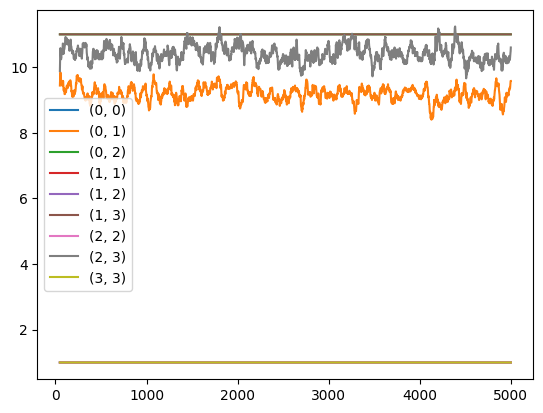

In [98]:
latency.rolling(window=50).mean().plot()

### 30 cars with closed middle edge

In [ ]:
cars = {
     0: Car( 0, 0, 3, 1/4, position=((0, 1), 0 / 4)),
     1: Car( 1, 0, 3, 1/4, position=((0, 1), 1 / 4)),
     2: Car( 2, 0, 3, 1/4, position=((0, 1), 2 / 4)),
     3: Car( 3, 0, 3, 1/4, position=((0, 1), 3 / 4)),
     4: Car( 4, 0, 3, 1/11, position=((1, 3), 0 / 11)),
     5: Car( 5, 0, 3, 1/11, position=((1, 3), 1 / 11)),
     6: Car( 6, 0, 3, 1/11, position=((1, 3), 2 / 11)),
     7: Car( 7, 0, 3, 1/11, position=((1, 3), 3 / 11)),
     8: Car( 8, 0, 3, 1/11, position=((1, 3), 4 / 11)),
     9: Car( 9, 0, 3, 1/11, position=((1, 3), 5 / 11)),
    10: Car(10, 0, 3, 1/11, position=((1, 3), 6 / 11)),
    11: Car(11, 0, 3, 1/11, position=((1, 3), 7 / 11)),
    12: Car(12, 0, 3, 1/11, position=((1, 3), 8 / 11)),
    13: Car(13, 0, 3, 1/11, position=((1, 3), 9 / 11)),
    14: Car(14, 0, 3, 1/11, position=((1, 3), 10 / 11)),
    15: Car(15, 0, 3, 1/11, position=((0, 2), 0 / 11)),
    16: Car(16, 0, 3, 1/11, position=((0, 2), 1 / 11)),
    17: Car(17, 0, 3, 1/11, position=((0, 2), 2 / 11)),
    18: Car(18, 0, 3, 1/11, position=((0, 2), 3 / 11)),
    19: Car(19, 0, 3, 1/11, position=((0, 2), 4 / 11)),
    20: Car(20, 0, 3, 1/11, position=((0, 2), 5 / 11)),
    21: Car(21, 0, 3, 1/11, position=((0, 2), 6 / 11)),
    22: Car(22, 0, 3, 1/11, position=((0, 2), 7 / 11)),
    23: Car(23, 0, 3, 1/11, position=((0, 2), 8 / 11)),
    24: Car(24, 0, 3, 1/11, position=((0, 2), 9 / 11)),
    25: Car(25, 0, 3, 1/11, position=((0, 2), 10 / 11)),
    26: Car(26, 0, 3, 1/4, position=((2, 3), 0 / 4)),
    27: Car(27, 0, 3, 1/4, position=((2, 3), 1 / 4)),
    28: Car(28, 0, 3, 1/4, position=((2, 3), 2 / 4)),
    29: Car(29, 0, 3, 1/4, position=((2, 3), 3 / 4)),
}

model = TrafficModel(network, cars)
model.network[1][2]['allowed'] = False

flow, latency, stats = run(model, 5000, verbose=False)

In [100]:
stats.groupby('route').count()

,source,target,steps
route,,,
"(0, 1, 3)",4855,4855,4855
"(0, 2, 3)",4757,4757,4757
"(1, 3)",11,11,11
"(2, 3)",4,4,4


In [101]:
stats.groupby('route').mean()

,source,target,steps
route,,,
"(0, 1, 3)",0.0,3.0,15.024099
"(0, 2, 3)",0.0,3.0,16.134539
"(1, 3)",0.0,3.0,5.000000
"(2, 3)",0.0,3.0,1.500000


In [102]:
stats['steps'].mean()

15.555728679754855

<Axes: >

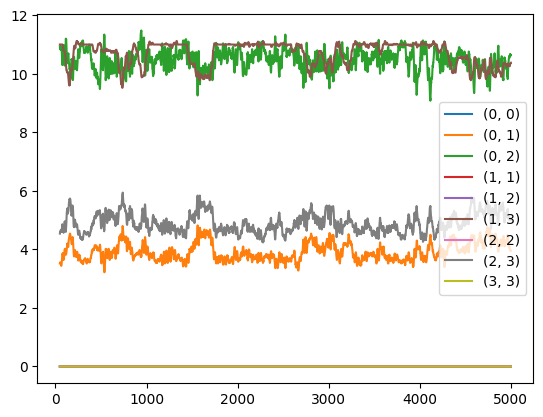

In [103]:
flow.rolling(window=50).mean().plot()

<Axes: >

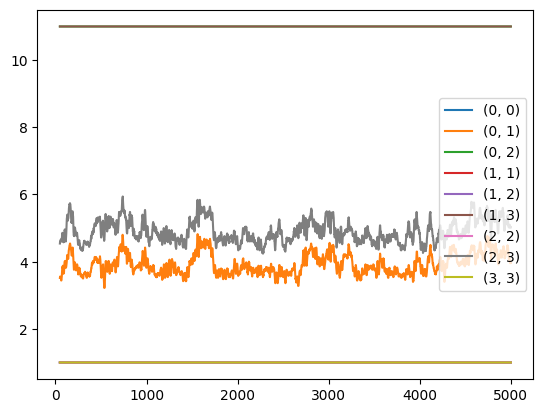

In [104]:
latency.rolling(window=50).mean().plot()